In [371]:
import networkx as nx
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas
from collections import Counter
import os

In [372]:
import biograph
import numpy as np
import pandas
import networkx as nx
import matplotlib.pyplot as plt

from biograph import graphplot
from biograph import hmrf_estimator
from biograph import probability_field_hmrf_estimator
from biograph import hmrf_em

import graphsonchip
import graphsonchip.analyse

from graphsonchip.graphmaker import make_spheroids
from graphsonchip.graphmaker import graph_generation_func
from graphsonchip.graphplotter import graph_plot

# Create graph

In [373]:
example_prop_frame = pandas.read_csv('C:\\Users\\bonne\\BioGraph\\Examples\\Examples_prop_210216_4_individual_tile_1.csv')
#example_prop_frame = pandas.read_csv('210303_18_cut_basic.csv')

loc = example_prop_frame[(example_prop_frame.x < 1500) & 
           (example_prop_frame.y < 1500) & 
           (example_prop_frame.z > 0) & 
           (example_prop_frame.z < 50)]

descriptors = ['label', 'cell_type', 'color']
n_colors = len(loc.cell_type.unique())

In [374]:
loc = loc.drop(columns = 'Unnamed: 0').drop(columns = 'Unnamed: 0.1')
loc.index = np.arange(len(loc))
loc['label'] = loc.index

In [396]:
loc['cell_type'] = loc.cell_type.values.astype(int)

color_list = [plt.cm.Set3(i) for i in range(n_colors)]
colors = [color_list[loc.loc[i, 'cell_type']] for i in range(len(loc))]

loc['color'] = colors

#legend_list = ['CD45+, dividing', 'CD45-, dividing', 'CD45+, not dividing', 'CD45-, not dividing']
#loc['legend'] = [legend_list[loc.loc[i, 'cell_type']] for i in range(len(loc))]

spheroid = make_spheroids.single_spheroid_process(loc,
                                       cell_descriptors = descriptors)

G = graph_generation_func.generate_voronoi_graph(spheroid, cell_descriptors = descriptors, dCells = 50)

In [378]:
color_list = [plt.cm.Set3(i) for i in range(n_colors)]
cell_class = nx.get_node_attributes(G, 'cell_type')

for node in G.nodes:    
    nx.set_node_attributes(G, {node:color_list[cell_class[node]]}, 'color')
    nx.set_node_attributes(G, {node:cell_class[node]}, 'legend')

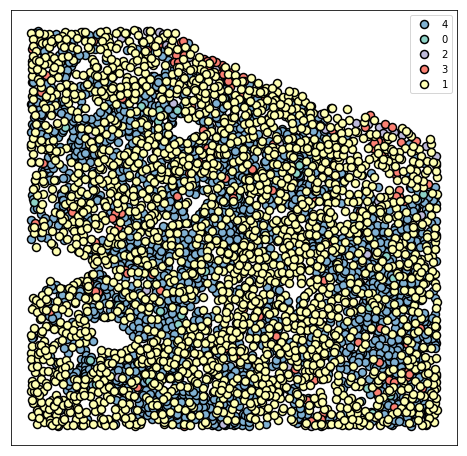

In [379]:
graphplot.scatter_plot_2D(G, 
                scatterpoint_size = 8,
                alpha_line = 0.1,
                legend = True,
                figsize = (8,8))

# Initiate first classes to start the algorithm

In [380]:
biograph = probability_field_hmrf_estimator.hmrf(G, epochs = 30, gamma = 0.4, K = 6)

In [381]:
biograph.initiate_latent_probability_field()

100%|███████████████████████████████████████████████████████████████████████████| 5015/5015 [00:00<00:00, 27034.57it/s]


In [382]:
def get_latent_probability_field_properties(G, number_of_cell_types):

    resultframe = pandas.DataFrame()
    i = 0
    
    latent_probability_field = nx.get_node_attributes(G, 'latent_probability_field')

    for node in sorted(G.nodes):
                
        for k in range(number_of_cell_types):
            resultframe.loc[i, k] = latent_probability_field[node][k]
            
        i += 1

    return resultframe.fillna(0)

In [383]:
latent_probability_field_properties = get_latent_probability_field_properties(biograph.graph, 
                                biograph.number_of_cell_types)

n_rows, n_cols = latent_probability_field_properties.shape
G = biograph.graph

X = latent_probability_field_properties.values.reshape(-1,n_cols)
X = preprocessing.StandardScaler().fit_transform(X)

In [384]:
# Apply kmeans algorithm to initiate
K = 6
kmeans = KMeans(n_clusters=K, random_state=0).fit(X)

In [385]:
color_list = [plt.cm.Set3(i) for i in range(K)]

In [386]:
for node in sorted(G.nodes):
            nx.set_node_attributes(G, {node:kmeans.labels_[node]}, 'class')
            nx.set_node_attributes(G, {node:color_list[kmeans.labels_[node]]}, 'color')
            nx.set_node_attributes(G, {node:kmeans.labels_[node]}, 'legend')

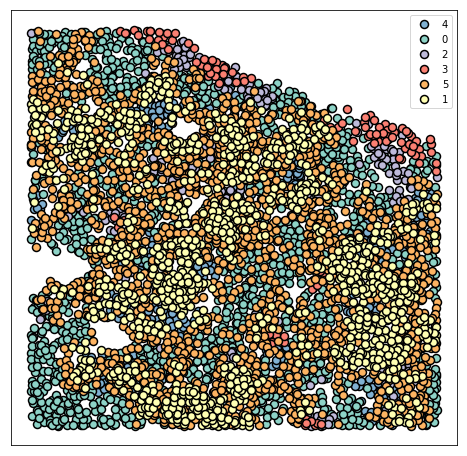

In [387]:
graphplot.scatter_plot_2D(G, 
                scatterpoint_size = 8,
                alpha_line = 0.1,
                legend = True,
                figsize = (8,8))

In [341]:
def categorical_vector(G, category):
    
    cat = nx.get_node_attributes(G, category)
    type_of_data = type(cat[0])
    V = np.array(list(cat.items()), dtype=type_of_data)
    a = map(int, V[:,0])
    a = np.array(list(a))
    ind = np.argsort(a)
    Vect = V[:,1][ind]
    
    return Vect

# For a categorical variable, convert vector from graph_to_numpy
# into a vector with 1 at positions for the desired value of the 
# category and 0 elsewhere

def desired_category_value(G, category, desired_value):
    
    Vect = categorical_vector(G, category)
    
    return np.multiply(Vect == desired_value, 1)

# Main part of the algo

In [324]:
# Function to update parameters

def update_parameters(G, K):

    # List of cell types
    cell_type_list = categorical_vector(G, 'cell_type')

    # Number of cells
    N = len(cell_type_list)

    # Number of cell types
    T = len(np.unique(cell_type_list))
    
    # Create matrix from cell type
    mat_cell_type = np.zeros((N, T))
    for i in range(N):
        mat_cell_type[i, cell_type_list[i]] = 1
    
    # List of labels
    cell_class_list = categorical_vector(G, 'class')

    # Number of cell labels
    classes, card_classes = np.unique(cell_class_list, return_counts=True)
    
    # Little trick to allow loosing some labels
    card_classes2 = np.zeros(K)
    card_classes2[classes] = card_classes
    card_classes = card_classes2

    # Count frequencies of cell types in each latent class
    freq = np.zeros((K, T))
    
    # Variability inside class
    sig = [np.eye(T) for j in range(K)]

    for j in range(K):
        
        # Count number of cells of each type in class j
        x1, x2 = np.unique(cell_type_list[cell_class_list == j], return_counts=True)
        freq[j, x1] = x2
        freq[j, :] /= card_classes[j]
        freq[j, :] /= np.sum(freq[j, :])
        
        # Compute variability inside class j
        cell_type_in_j = mat_cell_type[cell_class_list == j]
        sig_j = np.sum((cell_type_in_j - freq[j])**2, axis = 0)
        sig_j /= card_classes[j]
        sig[j] *= sig_j
          
    return freq, sig

In [126]:
# Initiate value of parameters
beta = 0
mu, sigma2 = update_parameters(G, K)

In [20]:
# Important quantities
cell_class_dict = nx.get_node_attributes(G, 'class') # dict of cell labels

cell_type_list = categorical_vector(G, 'cell_type') # list of cell types

N = len(cell_type_list) # Number of cell

T = len(np.unique(cell_type_list)) # Number of cell types

# Create matrix from cell type
mat_cell_type = np.zeros((N, T))
for i in range(N):
    mat_cell_type[i, cell_type_list[i]] = 1

In [21]:
# Influence of neighbors labels

log_P_neigh = np.zeros((len(G.nodes), K))

for node in G.nodes:

    neighbour_cell_class = [cell_class_dict[n] for n in G.neighbors(node)]
    neighbour_cell_class_counter = Counter(neighbour_cell_class)

    for cell_class in neighbour_cell_class_counter.keys():

        for k in range(K):
            log_P_neigh[node, k] += beta*int(k == cell_class)*neighbour_cell_class_counter[cell_class]

In [22]:
# Emission log-probability

log_P_gauss = np.zeros((len(G.nodes), K))

for j in range(K):
    var = sigma2[j]
    for i in range(N):
        xi = mat_cell_type[i]
        for t in range(T):
            a = (-0.5*(xi[t]-mu[j,t])**2)/var[t, t]
            if ~np.isnan(a):
                if a == -np.inf:
                    log_P_gauss[i, j] += -1e10
                else:
                    log_P_gauss[i, j] += a

C:\Users\bonne\Anaconda\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
C:\Users\bonne\Anaconda\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


In [23]:
# MAP criterion to determine new labels

sum_prob = log_P_gauss + log_P_neigh

new_class = np.argmax(sum_prob, axis=1)
#print(np.unique(new_class))

In [24]:
# Update labels in the graph

for node in sorted(G.nodes):
    nx.set_node_attributes(G, {node:new_class[node]}, 'class')
    nx.set_node_attributes(G, {node:color_list[new_class[node]]}, 'color')
    nx.set_node_attributes(G, {node:new_class[node]}, 'legend')

In [25]:
# Update values of parameters

mu, sigma2 = update_parameters(G, K)

C:\Users\bonne\Anaconda\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
C:\Users\bonne\Anaconda\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


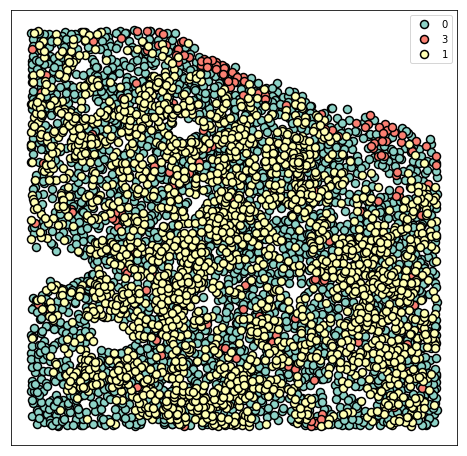

In [26]:
# Plot graph

graphplot.scatter_plot_2D(G, 
                scatterpoint_size = 8,
                alpha_line = 0.1,
                legend = True,
                figsize = (8,8))

# Make a loop

In [392]:
# Restart 
for node in sorted(G.nodes):
    nx.set_node_attributes(G, {node:kmeans.labels_[node]}, 'class')
    nx.set_node_attributes(G, {node:color_list[kmeans.labels_[node]]}, 'color')
    nx.set_node_attributes(G, {node:kmeans.labels_[node]}, 'legend')

In [393]:
# Initiate value of parameters
beta = 1000000
mu, sigma2 = update_parameters(G, K)

In [394]:
MU = [mu]
SIG = [sigma2]

for q in range(20):
    
    print(q)
    
    # Important quantities
    cell_class_dict = nx.get_node_attributes(G, 'class') # dict of cell labels

    cell_type_list = categorical_vector(G, 'cell_type') # list of cell types

    N = len(cell_type_list) # Number of cell

    T = len(np.unique(cell_type_list)) # Number of cell types

    # Create matrix from cell type
    mat_cell_type = np.zeros((N, T))
    for i in range(N):
        mat_cell_type[i, cell_type_list[i]] = 1

    # Influence of neighbors labels

    log_P_neigh = np.zeros((len(G.nodes), K))

    for node in G.nodes:

        neighbour_cell_class = [cell_class_dict[n] for n in G.neighbors(node)]
        neighbour_cell_class_counter = Counter(neighbour_cell_class)

        for cell_class in neighbour_cell_class_counter.keys():

            for k in range(K):
                log_P_neigh[node, k] += beta*int(k == cell_class)*neighbour_cell_class_counter[cell_class]
    
    # Emission log-probability

    log_P_gauss = np.zeros((len(G.nodes), K))
    
    for j in range(K):
        var = sigma2[j]
        for i in range(N):
            xi = mat_cell_type[i]
            for t in range(T):
                a = (-0.5*(xi[t]-mu[j,t])**2)/var[t, t]
                if ~np.isnan(a):
                    if a == -np.inf:
                        log_P_gauss[i, j] += -1e10
                    else:
                        log_P_gauss[i, j] += a
            
    # MAP criterion to determine new labels

    sum_prob = log_P_gauss + log_P_neigh

    new_class = np.argmax(sum_prob, axis=1)
    
    # Update labels in the graph
    
    for node in sorted(G.nodes):
        nx.set_node_attributes(G, {node:new_class[node]}, 'class')
        nx.set_node_attributes(G, {node:color_list[new_class[node]]}, 'color')
        nx.set_node_attributes(G, {node:new_class[node]}, 'legend')
        
    # Calculate new values of the parameter
    
    old_mu = np.copy(mu)
    old_sigma2 = np.copy(sigma2)
    mu, sigma2 = update_parameters(G, K)
    MU.append(mu)
    SIG.append(sigma2)
    
    stopCrit1 = np.max(np.abs(old_mu-mu))/(1 + max(np.linalg.norm(old_mu), np.linalg.norm(mu)))
    stopCrit2 = np.max(np.abs(old_sigma2-sigma2))/(1 + max(np.linalg.norm(old_sigma2), np.linalg.norm(sigma2)))
    
    print(stopCrit1, stopCrit2)
    

0


C:\Users\bonne\Anaconda\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\bonne\Anaconda\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars


0.08447151107312988 0.07386657068094887
1
0.027031752033426733 0.027838353290774834
2
0.021180431213081843 0.018603389254148707
3
0.010860043685427935 0.008823565119122002
4
0.009945321760076441 0.008048486591083873
5
0.010087047150194928 0.00735789046105796
6
0.00961985973768887 0.006974502463046836
7
0.007331049803390325 0.004583860411096166
8
0.01522907283054185 0.011372896621302656
9
0.015997299859265124 0.01321840501447533
10
0.004577623131791599 0.003929155681899836
11
0.005098095361895212 0.003929155681899836
12
0.004519102604122305 0.003925736923828577
13
0.004522194139284019 0.003925736923828577
14
0.004522194139284019 0.003924345563470439
15
0.004523167740213286 0.003924345563470439
16
0.004523167740213286 0.003923163736124416
17
0.004523491174834219 0.003923163736124416
18
0.004523491174834219 0.003923163736124416
19
0.004523491174834219 0.003923163736124416


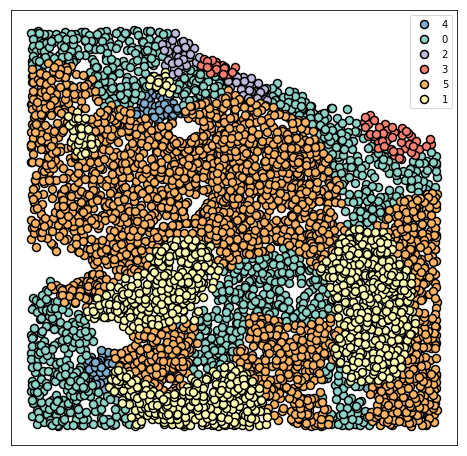

In [395]:
graphplot.scatter_plot_2D(G, 
                scatterpoint_size = 8,
                alpha_line = 0.1,
                legend = True,
                figsize = (8,8))

# Evolution of parameters during iterations

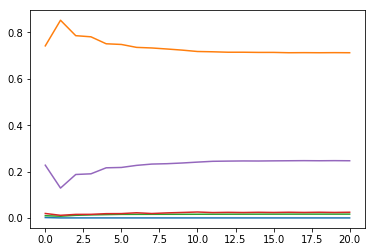

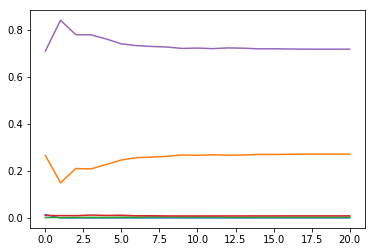

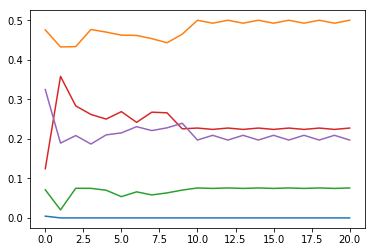

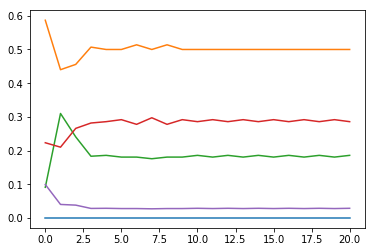

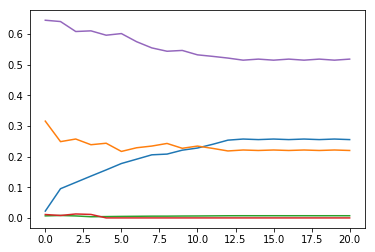

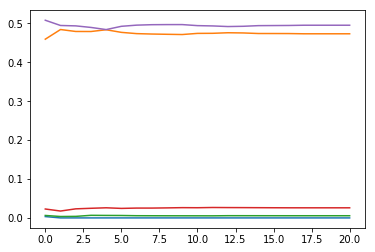

In [391]:
it = len(MU)
for j in range(K):
    plt.figure()
    l0 = []
    l1 = []
    l2 = []
    l3 = []
    l4 = []
    for q in range(it):
        l0.append(MU[q][j, 0])
        l1.append(MU[q][j, 1])
        l2.append(MU[q][j, 2])
        l3.append(MU[q][j, 3])
        l4.append(MU[q][j, 4])
    plt.plot(l0)
    plt.plot(l1)
    plt.plot(l2)
    plt.plot(l3)
    plt.plot(l4)
    plt.show()

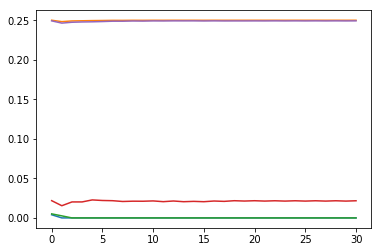

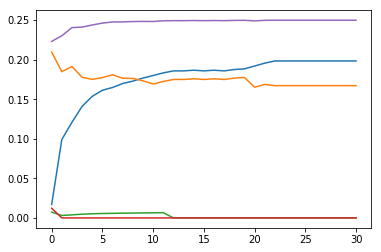

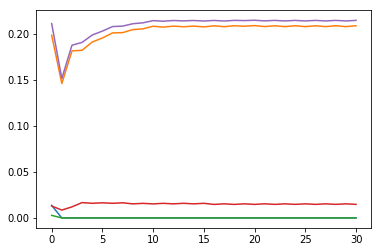

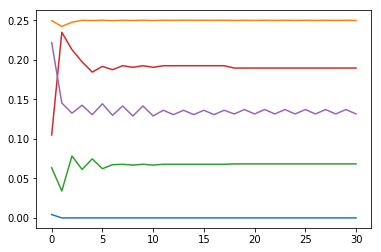

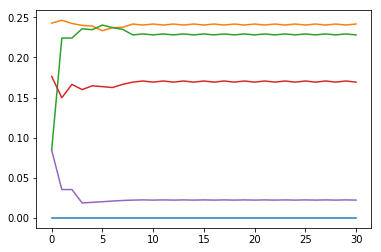

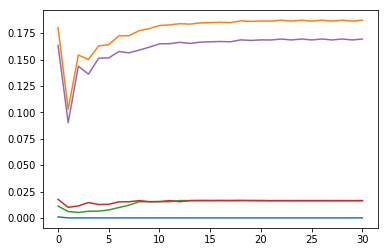

In [347]:
it = len(SIG)
for j in range(K):
    plt.figure()
    l0 = []
    l1 = []
    l2 = []
    l3 = []
    l4 = []
    for q in range(it):
        l0.append(SIG[q][j][0 , 0])
        l1.append(SIG[q][j][1 , 1])
        l2.append(SIG[q][j][2 , 2])
        l3.append(SIG[q][j][3 , 3])
        l4.append(SIG[q][j][4 , 4])
    plt.plot(l0)
    plt.plot(l1)
    plt.plot(l2)
    plt.plot(l3)
    plt.plot(l4)
    plt.show()

# Test on simple graph

In [156]:
# Create a basic graph :

columns = ['label', 'x', 'y', 'z', 'cell_type']
label = np.array([0, 1, 2, 3, 4])
x = np.array([10, 11, 9, 11, 9])
y = np.array([10, 11, 10, 9, 9])
z = np.array([10, 10, 10, 10, 10])
cell_type = np.array([1, 1, 0, 0, 2])

dtf = pandas.DataFrame([label, x, y, z, cell_type], columns)
dtf = dtf.T

descriptors = ['label', 'cell_type', 'color']
n_colors = len(dtf.cell_type.unique())

color_list = [plt.cm.Set3(i) for i in range(n_colors)]
colors = [color_list[dtf.loc[i, 'cell_type']] for i in range(len(dtf))]

dtf['color'] = colors

spheroid = make_spheroids.single_spheroid_process(dtf, cell_descriptors = descriptors)

cells = spheroid['cells']    

neighbors = [[0, 1], [0, 2], [0, 3], [1, 2], [2, 3], [1, 3], [2, 4]]

G=nx.Graph()

for n in neighbors:
        G.add_edge(n[0], n[1])

pos = {int(i): (cells[i]['z'], cells[i]['x'], cells[i]['y']) for i in cells.keys()}
ind = {int(i): cells[i]['cell_label'] for i in cells.keys()}

nx.set_node_attributes(G, pos, 'pos')
nx.set_node_attributes(G, ind, 'cell_label')

for descriptor in descriptors:

        desc = {int(i): (cells[i][descriptor]) for i in cells.keys()}
        nx.set_node_attributes(G, desc, descriptor)

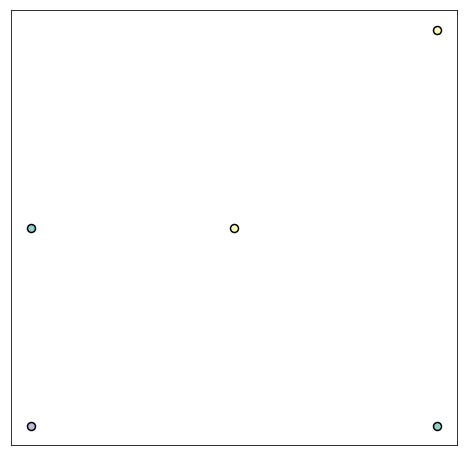

In [157]:
graphplot.scatter_plot_2D(G, 
                scatterpoint_size = 8,
                alpha_line = 0.1,
                legend = True,
                figsize = (8,8))

In [158]:
biograph = probability_field_hmrf_estimator.hmrf(G, epochs = 30, gamma = 0.4, K = 6)

In [159]:
biograph.initiate_latent_probability_field()

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 4091.21it/s]


In [160]:
latent_probability_field_properties = get_latent_probability_field_properties(biograph.graph, 
                                biograph.number_of_cell_types)

n_rows, n_cols = latent_probability_field_properties.shape
G = biograph.graph

X = latent_probability_field_properties.values.reshape(-1,n_cols)
X = preprocessing.StandardScaler().fit_transform(X)

In [161]:
# Apply kmeans algorithm to initiate
K = 3
kmeans = KMeans(n_clusters=K, random_state=0).fit(X)

In [162]:
for node in sorted(G.nodes):
            nx.set_node_attributes(G, {node:kmeans.labels_[node]}, 'class')
            nx.set_node_attributes(G, {node:color_list[kmeans.labels_[node]]}, 'color')
            nx.set_node_attributes(G, {node:kmeans.labels_[node]}, 'legend')

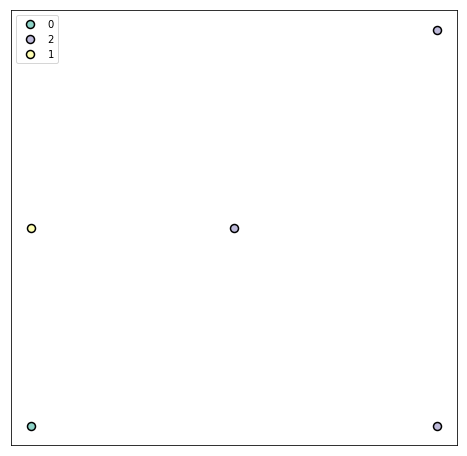

In [163]:
graphplot.scatter_plot_2D(G, 
                scatterpoint_size = 8,
                alpha_line = 0.1,
                legend = True,
                figsize = (8,8))

In [164]:
beta = 1

In [165]:
mu, sigma2 = new_param(G, K)

In [166]:
mu

array([[0.        , 0.        , 1.        ],
       [1.        , 0.        , 0.        ],
       [0.33333333, 0.66666667, 0.        ]])

In [167]:
sigma2

[array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]), array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]), array([[0.22222222, 0.        , 0.        ],
        [0.        , 0.22222222, 0.        ],
        [0.        , 0.        , 0.        ]])]

In [168]:
# Create matrix from cell type
cell_type_list = categorical_vector(G, 'cell_type')

# Number of cells
N = len(cell_type_list)
print('N = ', N)

# Number of cell types
T = len(np.unique(cell_type_list))
print('T = ', T)

mat_cell_type = np.zeros((N, T))
for i in range(N):
    mat_cell_type[i, cell_type_list[i]] = 1
print(mat_cell_type)

N =  5
T =  3
[[0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [169]:
# Influence of neighbors labels

cell_class_dict = nx.get_node_attributes(G, 'class')

log_P_neigh = np.zeros((len(G.nodes), K))

for node in G.nodes:
    #print('node', node)

    neighbour_cell_class = [cell_class_dict[n] for n in G.neighbors(node)]
    #print(neighbour_cell_class)
    neighbour_cell_class_counter = Counter(neighbour_cell_class)

    for cell_class in neighbour_cell_class_counter.keys():
        #print(cell_class, neighbour_cell_class_counter[cell_class])

        for k in range(K):
            log_P_neigh[node, k] += beta*int(k == cell_class)*neighbour_cell_class_counter[cell_class]
print(log_P_neigh)

[[0. 1. 2.]
 [0. 1. 2.]
 [1. 0. 3.]
 [0. 1. 2.]
 [0. 1. 0.]]


In [170]:
# Emission log-probability

log_P_gauss = np.zeros((len(G.nodes), K))

cell_type_list = categorical_vector(G,'cell_type')

# Number of cell types
T = len(np.unique(cell_type_list))

for j in range(K):
    var = sigma2[j]
    for i in range(N):
        xi = mat_cell_type[i]
        #ind = int(np.where(xi == 1)[0])
        for t in range(T):
            a = (-0.5*(xi[t]-mu[j,t])**2)/var[t, t]
            if ~np.isnan(a):
                if a == -np.inf:
                    log_P_gauss[i, j] += 1e-10
                else:
                    log_P_gauss[i, j] += a  #- 0.5*np.linalg.slogdet(var)[1]
print(log_P_gauss)

[[ 2.00e-10  2.00e-10 -5.00e-01]
 [ 2.00e-10  2.00e-10 -5.00e-01]
 [ 2.00e-10  0.00e+00 -2.00e+00]
 [ 2.00e-10  0.00e+00 -2.00e+00]
 [ 0.00e+00  2.00e-10 -1.25e+00]]


C:\Users\bonne\Anaconda\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
C:\Users\bonne\Anaconda\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


In [171]:
# MAP criterion to determine new labels

sum_prob = log_P_gauss + log_P_neigh
print(sum_prob)

new_class = np.argmax(sum_prob, axis=1)
print(new_class)

[[ 2.00e-10  1.00e+00  1.50e+00]
 [ 2.00e-10  1.00e+00  1.50e+00]
 [ 1.00e+00  0.00e+00  1.00e+00]
 [ 2.00e-10  1.00e+00  0.00e+00]
 [ 0.00e+00  1.00e+00 -1.25e+00]]
[2 2 0 1 1]


In [172]:
# MAP criterion to determine new labels

sum_prob = log_P_gauss + log_P_neigh

new_class = np.argmax(sum_prob, axis=1)

# Update labels in the graph

for node in sorted(G.nodes):
    nx.set_node_attributes(G, {node:new_class[node]}, 'class')
    nx.set_node_attributes(G, {node:color_list[new_class[node]]}, 'color')
    nx.set_node_attributes(G, {node:new_class[node]}, 'legend')

# Calculate new values of the parameter

mu, sigma2 = new_param(G, K)

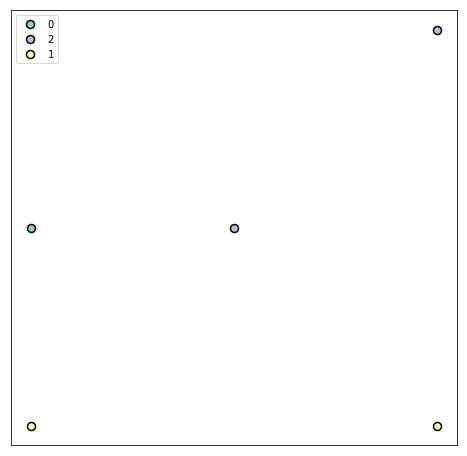

In [173]:
graphplot.scatter_plot_2D(G, 
                scatterpoint_size = 8,
                alpha_line = 0.1,
                legend = True,
                figsize = (8,8))

### Create random example graph

In [60]:
from collections import defaultdict
from scipy.spatial import Delaunay

In [61]:
def single_spheroid_process(spheroid_frame:pandas.DataFrame,
                            cell_descriptors:list = []
                            ):

    """

    spheroid_frame has the label of each cell as index.

    """

    assert set(['x', 'y']).issubset(spheroid_frame.columns)
    assert set(cell_descriptors).issubset(spheroid_frame.columns)
  
    spheroid = {}
  
    cells = {}

    for ind in spheroid_frame.index:

        unique_cell = {}
    
        unique_cell['x'] = spheroid_frame.loc[ind, 'x']
        unique_cell['y'] = spheroid_frame.loc[ind, 'y']
        unique_cell['cell_label'] = ind

        for descriptor in cell_descriptors:

            unique_cell[descriptor] = spheroid_frame.loc[ind, descriptor]
            
        cells[int(ind)] = unique_cell

    spheroid['cells'] = cells

    return spheroid

In [62]:
def prep_points(cells:dict):
    
    return [[cells[cell_label]['x'], cells[cell_label]['y']] for cell_label in cells.keys()]

In [63]:
def find_neighbors(tess):
    neighbors = defaultdict(set)

    for simplex in tess.simplices:        
        for idx in simplex:
                        
            other = set(simplex)            
            other.remove(idx)
            neighbors[idx] = neighbors[idx].union(other)

    return neighbors

In [64]:

def network_plot_2D(G,
                    include_color:bool = False,
                    edge_color:str = 'k', 
                    save:bool=False,
                    figsize:tuple = (8,8),
                    alpha_line = 0.6,
                    dim_to_squeeze = 'z',
                    scatterpoint_size = 20,
                    legend = False):

    # Get node positions
    pos = nx.get_node_attributes(G, 'pos')

    # Get number of nodes
    n = G.number_of_nodes()

    # Get the maximum number of edges adjacent to a single node
    edge_max = np.max([G.degree[i] for i in G])

    # Define color range proportional to number of edges adjacent to a single node
    colors = nx.get_node_attributes(G, 'color')

    if legend:

      legend = nx.get_node_attributes(G, 'legend')

    fig, ax = plt.subplots(figsize = figsize)

    # Loop on the pos dictionary to extract the x,y,z coordinates of each node

    for i,j in enumerate(G.edges()):

        x = np.array((pos[j[0]][0], pos[j[1]][0]))
        y = np.array((pos[j[0]][1], pos[j[1]][1]))

        # Plot the connecting lines
        plt.plot(x, y, c = 'k', alpha = alpha_line)

    x = []
    y = []
    nodeColor = []
    s = []
    nodelegend = []

    for key, value in pos.items():
        x.append(value[0])
        y.append(value[1])
        s.append(scatterpoint_size)
        nodeColor.append(colors[key])

        if legend:
          nodelegend.append(legend[key])

    df = pandas.DataFrame()
    df['x'] = x
    df['y'] = y
    df['s'] = s
    df['nodeColor'] = nodeColor

    if legend:
      df['legend'] = nodelegend

    groups = df.groupby('nodeColor')

    for nodeColor, group in groups:

      if legend:

        name = group.legend.unique()[0]

        ax.plot(group.x, group.y, 
          marker='o', 
          c=nodeColor,
          markeredgewidth=1.5, 
          markeredgecolor= 'k',
          linestyle='', 
          ms=scatterpoint_size, 
          label=name)

        ax.legend()

      else:

        ax.plot(group.x, group.y, 
          marker='o', 
          c=nodeColor,
          markeredgewidth=1.5, 
          markeredgecolor= 'k',
          linestyle='', 
          ms=scatterpoint_size)

    # Scatter plot
    #sc = ax.scatter(x, y, c=nodeColor, s=s, edgecolors='k', alpha=1)
    
    # Remove tick labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # No ticks
    ax.set_xticks([]) 
    ax.set_yticks([]) 

In [65]:
# Create a basic graph random :

#N Number of nodes / Nct Number of cell types / Nedges Number of edges

def random_graph(N, Nct):

    columns = ['label', 'x', 'y', 'z', 'cell_type']
    label = np.array([i for i in range(N)])
    x = np.array([np.random.randint(0, 21) for i in range(N)])
    y = np.array([np.random.randint(0, 21) for i in range(N)])
    z = np.array([0 for i in range(N)])
    cell_type = np.array([np.random.randint(0, Nct) for i in range(N)])
    dtf = pandas.DataFrame([label, x, y, z, cell_type], columns)
    dtf = dtf.T

    descriptors = ['label', 'cell_type', 'color']
    n_colors = len(dtf.cell_type.unique())

    color_list = [plt.cm.Set3(i) for i in range(n_colors)]
    colors = [color_list[dtf.loc[i, 'cell_type']] for i in range(len(dtf))]

    dtf['color'] = colors

    spheroid = make_spheroids.single_spheroid_process(dtf, cell_descriptors = descriptors)

    cells = spheroid['cells']    
    cells_pos = prep_points(cells)
    tri = Delaunay(cells_pos)

    G=nx.Graph()

    neighbors = find_neighbors(tri)
    
    neighbors = dict(neighbors)

    for key in neighbors:
        for node in neighbors[key]:

            G.add_edge(key, node)

    pos = {int(i): (cells[i]['x'], cells[i]['y']) for i in cells.keys()}
    ind = {int(i): cells[i]['cell_label'] for i in cells.keys()}

    nx.set_node_attributes(G, pos, 'pos')
    nx.set_node_attributes(G, ind, 'cell_label')

    for descriptor in descriptors:

            desc = {int(i): (cells[i][descriptor]) for i in cells.keys()}
            nx.set_node_attributes(G, desc, descriptor)

    return G

In [165]:
G = random_graph(N = 15, Nct = 3)

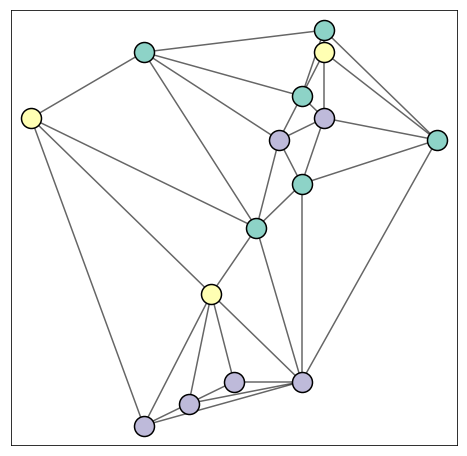

In [166]:
network_plot_2D(G, 
                           include_color = False,
                           edge_color = 'k', 
                           save=False,
                           figsize = (8,8),
                           alpha_line = 0.6,
                           dim_to_squeeze = 'z',
                           scatterpoint_size = 20,
                           legend = False)

100%|███████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 15029.76it/s]
C:\Users\bonne\Anaconda\lib\site-packages\biograph\hmrf_em.py:113: RuntimeWarning: invalid value encountered in double_scalars
  a = (-0.5*(xi[t]-self.mu[j,t])**2)/var[t, t]
C:\Users\bonne\Anaconda\lib\site-packages\biograph\hmrf_em.py:113: RuntimeWarning: divide by zero encountered in double_scalars
  a = (-0.5*(xi[t]-self.mu[j,t])**2)/var[t, t]
C:\Users\bonne\Anaconda\lib\site-packages\biograph\hmrf_em.py:171: RuntimeWarning: invalid value encountered in true_divide
  freq[j, :] /= card_classes[j]
C:\Users\bonne\Anaconda\lib\site-packages\biograph\hmrf_em.py:177: RuntimeWarning: invalid value encountered in true_divide
  sig_j /= card_classes[j]


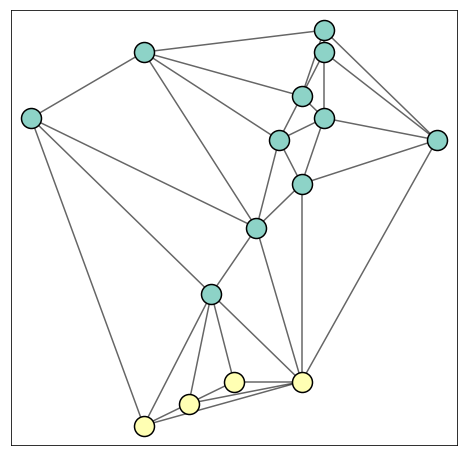

In [172]:
model = hmrf_em.hmrf(G, K = 3, beta = 1.5, max_it = 30)
model.initiate_model()
model.run()
network_plot_2D(model.graph, 
                           include_color = False,
                           edge_color = 'k', 
                           save=False,
                           figsize = (8,8),
                           alpha_line = 0.6,
                           dim_to_squeeze = 'z',
                           scatterpoint_size = 20,
                           legend = False)

100%|███████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 15065.75it/s]
C:\Users\bonne\Anaconda\lib\site-packages\biograph\hmrf_em.py:113: RuntimeWarning: invalid value encountered in double_scalars
  a = (-0.5*(xi[t]-self.mu[j,t])**2)/var[t, t]
C:\Users\bonne\Anaconda\lib\site-packages\biograph\hmrf_em.py:113: RuntimeWarning: divide by zero encountered in double_scalars
  a = (-0.5*(xi[t]-self.mu[j,t])**2)/var[t, t]


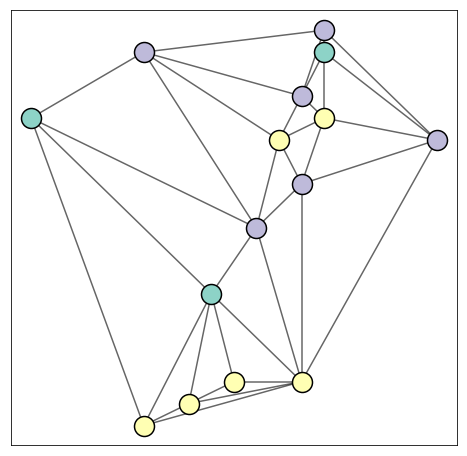

In [170]:
model = hmrf_em.hmrf(G, K = 3, beta = 0, max_it = 30)
model.initiate_model()
model.run()
network_plot_2D(model.graph, 
                           include_color = False,
                           edge_color = 'k', 
                           save=False,
                           figsize = (8,8),
                           alpha_line = 0.6,
                           dim_to_squeeze = 'z',
                           scatterpoint_size = 20,
                           legend = False)

100%|████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 7521.17it/s]
C:\Users\bonne\Anaconda\lib\site-packages\biograph\hmrf_em.py:113: RuntimeWarning: invalid value encountered in double_scalars
  a = (-0.5*(xi[t]-self.mu[j,t])**2)/var[t, t]
C:\Users\bonne\Anaconda\lib\site-packages\biograph\hmrf_em.py:113: RuntimeWarning: divide by zero encountered in double_scalars
  a = (-0.5*(xi[t]-self.mu[j,t])**2)/var[t, t]
C:\Users\bonne\Anaconda\lib\site-packages\biograph\hmrf_em.py:171: RuntimeWarning: invalid value encountered in true_divide
  freq[j, :] /= card_classes[j]
C:\Users\bonne\Anaconda\lib\site-packages\biograph\hmrf_em.py:177: RuntimeWarning: invalid value encountered in true_divide
  sig_j /= card_classes[j]


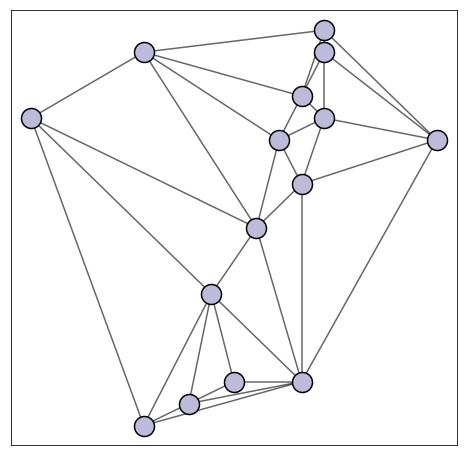

In [171]:
model = hmrf_em.hmrf(G, K = 3, beta = 10, max_it = 10)
model.initiate_model()
model.run()
network_plot_2D(model.graph, 
                           include_color = False,
                           edge_color = 'k', 
                           save=False,
                           figsize = (8,8),
                           alpha_line = 0.6,
                           dim_to_squeeze = 'z',
                           scatterpoint_size = 20,
                           legend = False)

In [244]:
from scipy.spatial import distance_matrix

In [249]:
cell_class_list = categorical_vector(G, 'class')

cell_type_list = categorical_vector(G, 'cell_type') # list of cell types

N = len(cell_type_list) # Number of cell

T = len(np.unique(cell_type_list)) # Number of cell types

# Create matrix from cell type
mat_cell_type = np.zeros((N, T))
for i in range(N):
    mat_cell_type[i, cell_type_list[i]] = 1

In [283]:
CT = []

for j in range(6):
    ct_j = mat_cell_type[cl == j]
    D = np.tril(distance_matrix(ct_j,ct_j))
    CT.append([np.sum(D), len(ct_j)])
    
CT = np.array(CT)
W = np.sum(CT[:,0]/CT[:,1])

In [302]:
W = []

# Apply kmeans algorithm to initiate
for K in range(2, 14):
    print(K)
    
    kmeans = KMeans(n_clusters=K, random_state=0).fit(X)

    color_list = [plt.cm.Set3(i) for i in range(K)]

    for node in sorted(G.nodes):
                nx.set_node_attributes(G, {node:kmeans.labels_[node]}, 'class')
                nx.set_node_attributes(G, {node:color_list[kmeans.labels_[node]]}, 'color')
                nx.set_node_attributes(G, {node:kmeans.labels_[node]}, 'legend')
                
                
    cell_class_list = categorical_vector(G, 'class')
    #print(cell_class_list)

    cell_type_list = categorical_vector(G, 'cell_type') # list of cell types
    #print(cell_type_list)

    N = len(cell_type_list) # Number of cell

    T = len(np.unique(cell_type_list)) # Number of cell types

    # Create matrix from cell type
    mat_cell_type = np.zeros((N, T))
    for i in range(N):
        mat_cell_type[i, cell_type_list[i]] = 1
    
    CT = []

    for j in range(K):
        ct_j = mat_cell_type[cl == j]
        D = np.tril(distance_matrix(ct_j,ct_j))
        CT.append([np.nansum(D), len(ct_j)])

    CT = np.array(CT)
    w = np.nansum(CT[:,0]/CT[:,1])
    W.append(w)

2
3
4
5
6
7


C:\Users\bonne\Anaconda\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


8
9
10
11
12
13


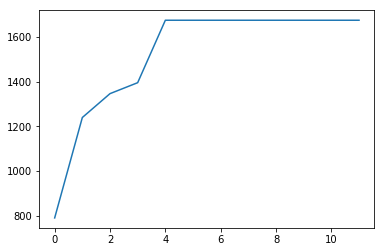

In [303]:
plt.plot(W)

In [304]:
W

[789.2092305299583,
 1239.2149120361714,
 1346.2016725122094,
 1395.291661931533,
 1675.1124935393832,
 1675.1124935393832,
 1675.1124935393832,
 1675.1124935393832,
 1675.1124935393832,
 1675.1124935393832,
 1675.1124935393832,
 1675.1124935393832]

In [301]:
CT

array([[1.14406907e+06, 1.74700000e+03],
       [5.44047957e+04, 4.05000000e+02],
       [6.52508238e+05, 1.45000000e+03],
       [2.51418887e+04, 2.35000000e+02],
       [5.79261875e+03, 1.18000000e+02],
       [2.96610082e+05, 1.06000000e+03],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00]])